In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt # plotting
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import os # accessing directory structure
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string
import pickle


import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yodhasudarsi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("publlic-comments.csv")
data.head()

,serial number,category,topic,Text,attributes
0,01-000001-0,emotion,Making do with it will only disgust yourself ...,"Life is short, be kind to yourself on the way...",positive
1,01-000001-1,emotion,Making do with it will only disgust yourself ...,Never throw away someone who has been with yo...,positive
2,01-000001-2,emotion,Making do with it will only disgust yourself ...,"If it’s not suitable, don’t settle for it.",neutral
3,01-000001-3,emotion,Making do with it will only disgust yourself ...,There is no such thing as getting something f...,positive
4,01-000001-4,emotion,Making do with it will only disgust yourself ...,It’s okay. Listen to what others say about you...,neutral


In [4]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
serial number,0
category,0
topic,10
Text,2
attributes,0


In [5]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")


No. of rows removed : 12

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [6]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset='Text')
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 1

Percentage of data removed: 0.0%
Percentage of data remaining: 99.99%


In [7]:
data[['Text', 'attributes']].sample(5)

,Text,attributes
63871,I was actually planted in Gulangyu [Yunbei] a...,neutral
71617,"The acting is really great, and the plot is a...",negative
114546,Samsung’s system still needs to be strengthened,negative
160080,"Science, education, culture and health are th...",positive
31027,Asking for the original picture sisters [heart...,positive


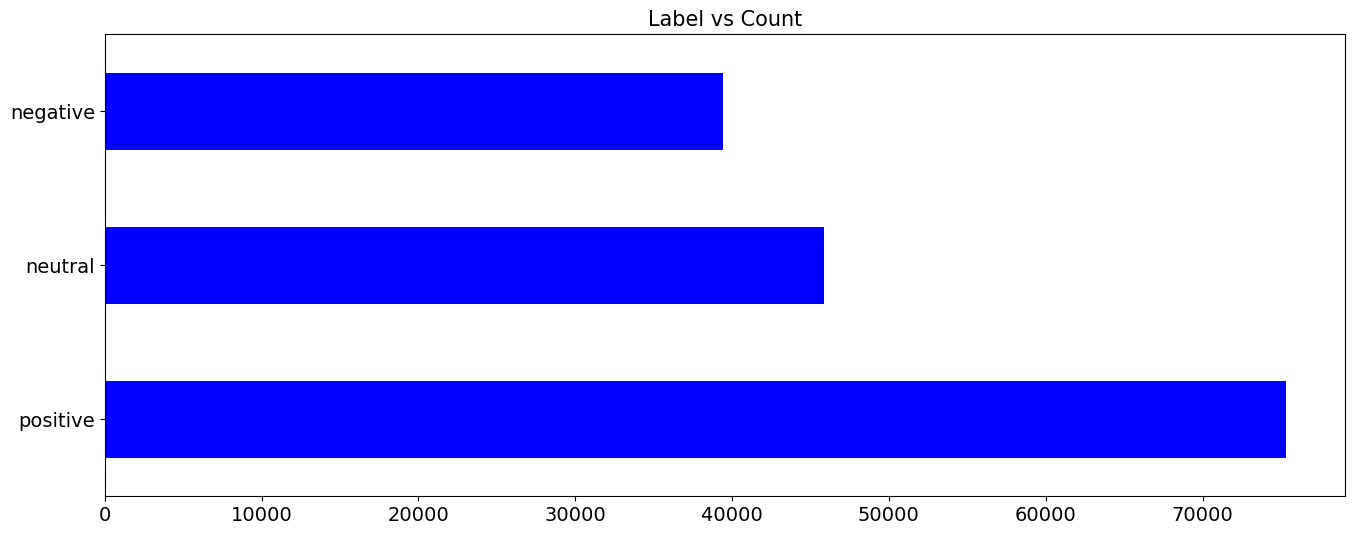

In [8]:
fig,ax = plt.subplots(figsize=(16, 6))

vc = data.attributes.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [9]:
neutral = data.loc[data['attributes'] == "neutral"].iloc[:37000]
positive = data.loc[data['attributes'] == "positive"].iloc[:38000]
negative = data.loc[data['attributes'] == "negative"].iloc[:40000]
data = pd.concat([positive, negative, neutral])
data.shape

(114410, 5)

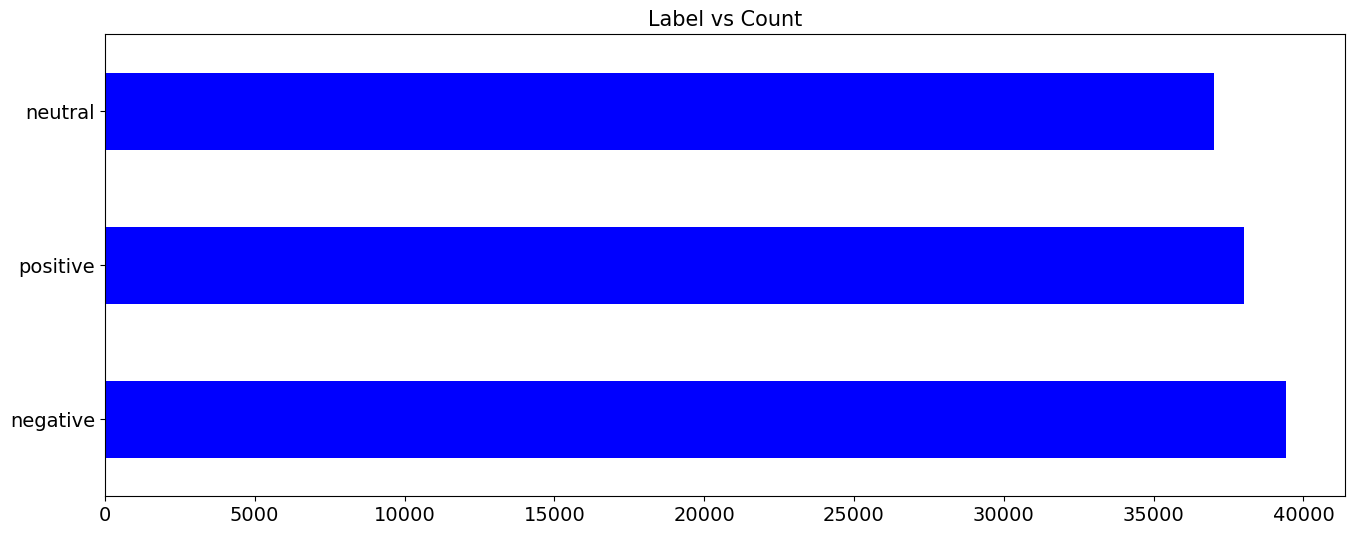

In [10]:
fig,ax = plt.subplots(figsize=(16, 6))

vc = data.attributes.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [11]:
print("Before preprocessing : ")
data.Text.iloc[9]

Before preprocessing : 


' Happiness makes you fat'

In [12]:
# stopwords
from nltk.corpus import stopwords

# Get the total set of English stopwords
total_stopwords = set(stopwords.words('english'))

# Define negative stop words to exclude
negative_stop_words = set(word for word in total_stopwords 
                          if 'no' in word or 'not' in word)
# negative_stop_words = for word in total_stopwords if word.endswith("n't")

# Subtract negative stop words from total_stopwords
final_stopwords = total_stopwords - negative_stop_words

# Add additional stop words if needed
final_stopwords.add("one")

# 
final_stopwords.add("one")
print(final_stopwords)

{'it', 'as', 'itself', 'under', "you've", 'he', 'does', 'an', 'we', 'my', "should've", 'after', 'aren', 'into', 'who', 'why', 'did', 'ourselves', "couldn't", 'or', 'down', 'ma', 'wasn', "weren't", 'our', 'too', 'didn', 'mightn', 'll', 'through', 'them', 'will', 'in', 'am', "didn't", 'and', "wouldn't", "doesn't", 'if', 'wouldn', 'she', "needn't", 'mustn', 't', 'a', 'weren', 'one', 'some', 'been', 'those', 'me', "hadn't", 'once', 'off', 're', 'won', 'hers', 'before', 'because', 'most', 'such', 'hasn', 'their', 'very', 'him', 'needn', 'with', 'here', 'whom', 'themselves', 'herself', 'over', 'is', 'isn', 'other', 'doesn', 'what', "isn't", "mustn't", 'can', 'shan', 'yours', 'until', 'your', 'himself', "won't", "you'll", 'against', 's', 'how', 'theirs', 'of', 'on', "wasn't", 'which', 'each', 'm', "hasn't", 'between', 'hadn', "shan't", 'shouldn', 'ours', 'had', 'but', 'his', 'than', 'again', 'own', 'don', 'should', 'o', 'i', 'at', 'out', 'd', 'ain', "shouldn't", 'doing', "you're", "that'll", 

In [13]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [14]:
def preprocessor(Text):
    # remove html tags
    Text = HTMLTAGS.sub(r'', Text)

    # remove puncutuation
    Text = Text.translate(table)
    
    # remove digits
    Text = Text.translate(remove_digits)
    
    # lower case all letters
    Text = Text.lower()
    
    # replace multiple white spaces with single space
    Text = MULTIPLE_WHITESPACE.sub(" ", Text).strip()
    
    # remove stop words
    Text = [word for word in Text.split()
              if word not in final_stopwords]
    
    # stemming
    Text = ' '.join([stemmer.stem(word) for word in Text])
    
    
    return Text

In [15]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[9]

After preprocessing : 


'happi make fat'

In [16]:
from nltk.corpus import stopwords
from wordcloud import WordCloud


# Get the total set of English stopwords
STOPWORDS = set(stopwords.words('english'))

In [17]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

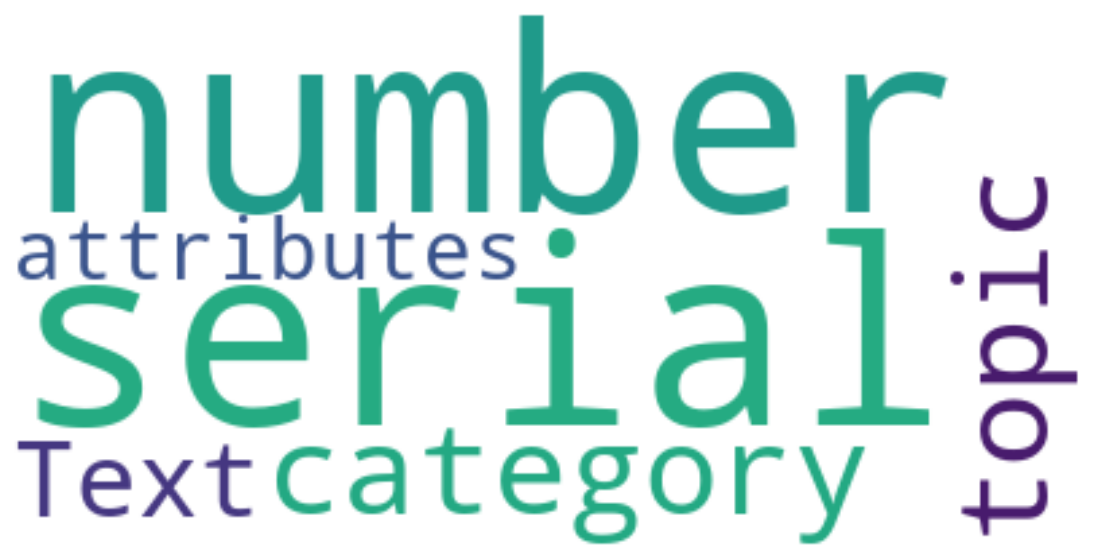

In [18]:
pos = data.loc[data.attributes=="Positive"]
text = " ".join(Text for Text in pos.astype(str))

generate_wcloud(text)

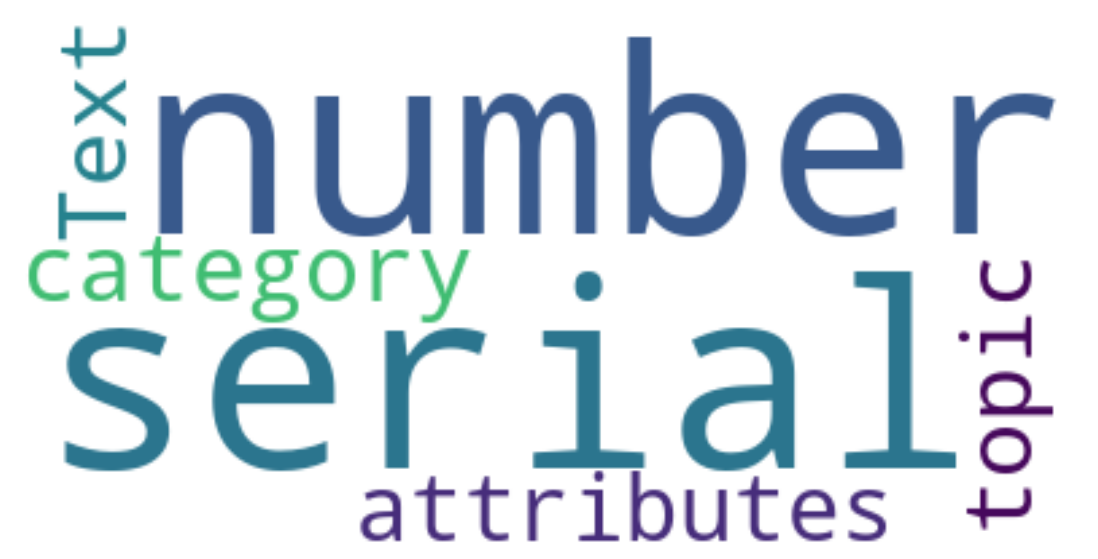

In [19]:
pos = data.loc[data.attributes=="Negative"]
text = " ".join(Text for Text in pos.astype(str))

generate_wcloud(text)

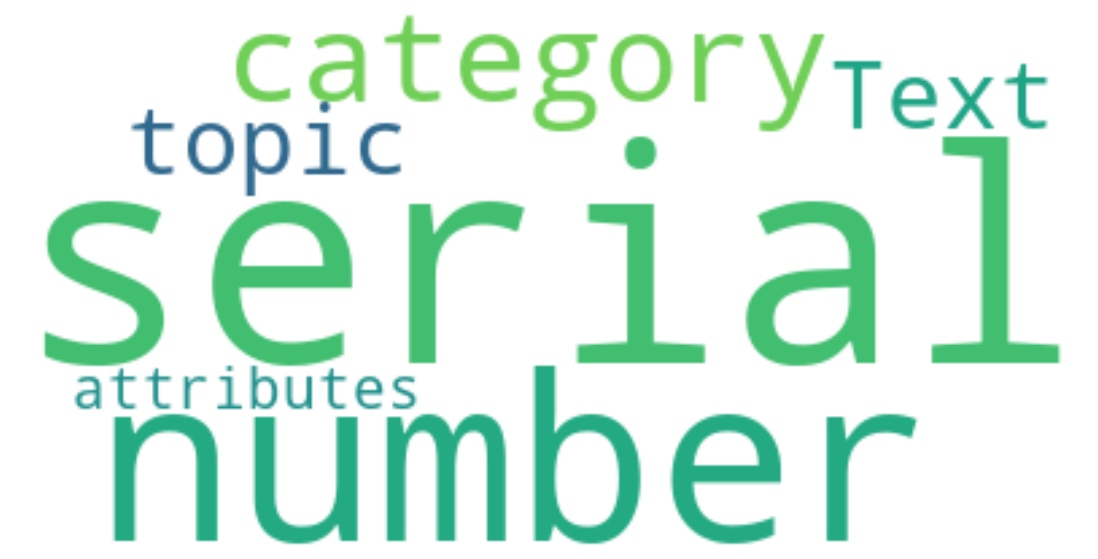

In [20]:
pos = data.loc[data.attributes=="Neutral"]
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

In [21]:
X = data.Text
y = data.attributes

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [22]:
X_train.shape, X_test.shape

((91528,), (22882,))

In [23]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [25]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['negative', 'neutral', 'positive']


In [26]:
### 
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')


In [27]:
from sklearn.metrics import accuracy_score

# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.40171313696355215
Test accuracy score : 0.37938117297439033

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.4460820732453457
Test accuracy score : 0.3939340966698715

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.4946245957521196
Test accuracy score : 0.39598811292719166

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.5204418320076917
Test accuracy score : 0.39310374967223144

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.5270518311336422
Test accuracy score : 0.3898697666287912

 ----------------------------------------


In [28]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.49388165370159953
Test accuracy score : 0.3986102613407919

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.49297482737522946
Test accuracy score : 0.39839174897299184

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.4913578358535093
Test accuracy score : 0.399528013285552

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.4906148938029892
Test accuracy score : 0.399659120706232

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.48972991871339916
Test accuracy score : 0.39930950091775197

 ----------------------------------------


In [29]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.34838519360195785
Test accuracy score : 0.34813390437898784

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.4209968534219037
Test accuracy score : 0.38960755178743117

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.47312297876059783
Test accuracy score : 0.4009701949130321

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.5141486758150511
Test accuracy score : 0.40053317017743206

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.5280242111703523
Test accuracy score : 0.3955510881915916

 ----------------------------------------


In [30]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.5108928415348308
Test accuracy score : 0.40402936806223233

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.5096145441832007
Test accuracy score : 0.4046849051656324

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.5069377676776505
Test accuracy score : 0.40455379774495237

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.5055502141421204
Test accuracy score : 0.40451009527139237

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.5046980159077004
Test accuracy score : 0.40324272353815227

 ----------------------------------------


In [31]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

In [32]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [33]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [34]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.5141486758150511
Test accuracy score : 0.40053317017743206


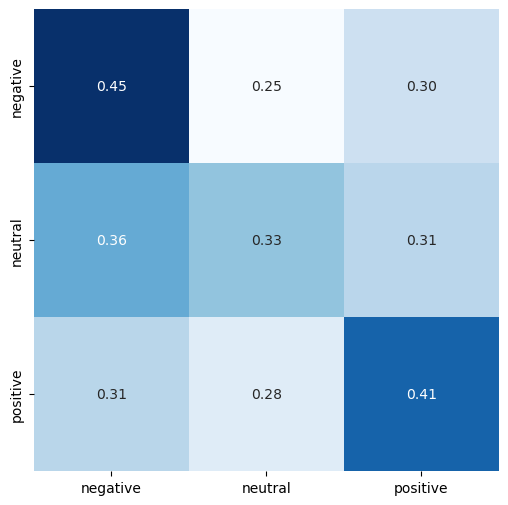

In [35]:
plot_cm(y_test, y_preds_test)

In [36]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

In [37]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [38]:
# positve review
review = "Today is a great day"
print(f"This is a {get_sentiment(review)} review!")

This is a neutral review!


In [50]:
review = "You are awesome, my friend. Thank you for helping me"
print(f"This is a {get_sentiment(review)} review!")

This is a neutral review!
